# Writing custom scikit-learn transformers

The scikit-learn's transformers API is a great tool for data cleaning, preprocessing, feature engineering and extraction. Sometimes, however, none of the wide range of availble transformers matches the specific problem at hand. On these occasions, it is handy to be able to write one oneself. Luckily, it's straightforward to leverage scikit-learns classes to build a transformer that follows the package's conventions and can be included in the scikit-learn pipelines.

### Problem setting

To make it practical, let's look at an example. We have a data set called `TAO`, which stands for Tropical Atmosphere Ocean. It contains some weather measurements such as temperature, humidity or wind speed. A subsample of these data comes with the R library `VIM`. Here, we are working with a slightly preprocessed version.

A quick look at the data frame tells us there is a substantial number of missing values in the `air_temp` variable, which we will need to impute before modeling. Scikit-learn offers imputing transformers such as `SimpleImputer` which fills-in the variable's missing values by its mean, median or some other quantity. However, such imputation is known to destroy relations in the data. But look, there is another variable called `sea_surface_temp` with no missing values! We could expect water temperature to be highly correlated with air temperature! Let's plot these two variables against each other.

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

tao = pd.read_csv("tao.csv").dropna(subset=["sea_surface_temp"]).reset_index(drop=True)

In [126]:
tao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 8 columns):
year                733 non-null int64
latitude            733 non-null int64
longitude           733 non-null int64
sea_surface_temp    733 non-null float64
air_temp            655 non-null float64
humidity            642 non-null float64
uwind               733 non-null float64
vwind               733 non-null float64
dtypes: float64(5), int64(3)
memory usage: 45.9 KB


In [187]:
tao.head()

,year,latitude,longitude,sea_surface_temp,air_temp,humidity,uwind,vwind
0,1997,0,-110,27.59,27.15,79.6,-6.4,5.4
1,1997,0,-110,27.55,27.02,75.8,-5.3,5.3
2,1997,0,-110,27.57,27.00,76.5,-5.1,4.5
3,1997,0,-110,27.62,26.93,76.2,-4.9,2.5
4,1997,0,-110,27.65,26.84,76.4,-3.5,4.1


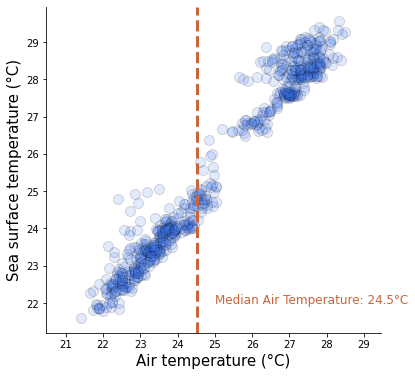

In [189]:
def plot_temperatures(tao):
    plt.figure(figsize=(6, 6))
    plt.scatter(tao.air_temp, tao.sea_surface_temp, color='xkcd:lightish blue',
               alpha=0.15, s=100, edgecolor="black", label="Observed")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.axis("equal")
    plt.xlabel("Air temperature (°C)", fontsize=15)
    plt.ylabel("Sea surface temperature (°C)", fontsize=15)
    plt.axvline(tao.air_temp.median(), linestyle='--', lw=3, 
                zorder=1, color='xkcd:terra cotta')
    plt.annotate(f"Median Air Temperature: {tao.air_temp.median():.1f}°C", 
                 (25, 22), 
                 fontsize=12,
                 color='xkcd:terra cotta')

plot_temperatures(tao)
plt.show()

As we expected, there is a clear linear relation. Also, we can see why mean or median imputation makes no sense: setting air temperature to its median value of 24.5 degrees for observations where water temperature is 22 or 29 completely destroys the relation between these two variables.

It seems that a good strategy for imputing `air_temp` would be with linear regression, with `sea_surface_temp` as a predictor. As of scikit-learn version 0.21, we can use the `IterativeImputer` and set `LinearRegression` as the imputing engine. However, this will use all the variables in the data as predictors, while we only want the water temperature. Let's write our own transformer to achieve this.

### Custom transformer

A scikit-learn transformer should be a class implementing three methods:
* `fit()`, which simply returns `self`,
* `transform()`, which takes the data 'X' as input and performs desired transformations,
* `fit_transform()`, which is added automatiacally if you include `TransformerMixin` as a base class.

On top of these, we have the `__init__()` to capture and pass parameters - in our example the indices of air and water temperature columns. We can also include `BaseEstimator` as a base class, which allows us to retrieve the parameters from the transformer object.

This means all the effort boils down to actually writing the `transform()` method that fits the linear regression model using the appropriate columns and uses it to impute air temperature. This is done in just a few lines of code:

In [180]:
class LinearRegressionTemperatureImputer(BaseEstimator, TransformerMixin):

    def __init__(self, air_temp_index=None, sea_temp_index=None):
        self.air_temp_index = air_temp_index
        self.sea_temp_index = sea_temp_index
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_reg = X[~np.isnan(X)[:, self.air_temp_index]]
        reg_model = LinearRegression()
        reg_model.fit(X_reg[:, self.sea_temp_index].reshape(-1, 1), 
                      X_reg[:, self.air_temp_index])
        preds = reg_model.predict(X[:, self.sea_temp_index].reshape(-1, 1))
        X[:, self.air_temp_index] = preds
        return X

We can now use our imputer like this:

In [181]:
temp_imputer = LinearRegressionTemperatureImputer(
    air_temp_index=4, sea_temp_index=3
)
tao_imputed = temp_imputer.transform(tao.values)

We can also extract its parameters:

In [186]:
temp_imputer.get_params()

{'air_temp_index': 4, 'sea_temp_index': 3}

Let's check if the imputer worked well by plotting the imputed values on top of the previous scatter plot.

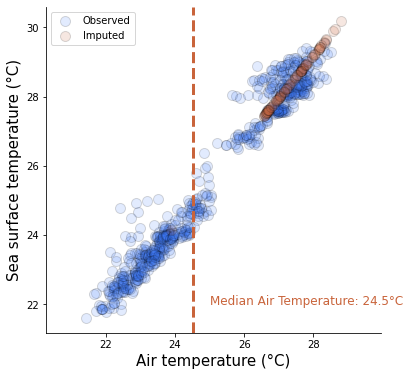

In [179]:
tao_imputed = pd.DataFrame(tao_imputed, columns=tao.columns, index=tao.index)
missing_air_temp_indices = tao.loc[np.isnan(tao.air_temp)].index
imputed_rows = tao_imputed.iloc[missing_air_temp_indices]

plot_temperatures(tao)
plt.scatter(imputed_rows.air_temp, imputed_rows.sea_surface_temp, color='xkcd:terra cotta',
           alpha=0.15, s=100, edgecolor="black", label="Imputed")
plt.legend()
plt.show()

Looks good: all imputed data points are on a single line, which should be the case for linear regression predictions. More importantly, the imputed data look similar to the observed ones.